In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [223]:
pd.set_option('display.max_colwidth', None)

In [224]:
reddit_data_df = pd.read_csv('../datasets/reddit_data_engineered.csv')

In [225]:
# reddit_data_df.set_index('id', inplace = True)

In [226]:

wn = WordNetLemmatizer()

In [227]:
## custom Tim funcion for mapping nltk POS_TAG for wordnet lemmatizing
def custom_lemmatize(word, tag):
    mapper = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    pos = mapper.get(tag[0])
    
    return wn.lemmatize(word, pos) if pos else word

### Stem

In [228]:
# reddit_data_df['title'].apply(lambda title: [ps.stem(word) for word in title.split()])

### Lemmatize

In [229]:
reddit_data_df['title'] = reddit_data_df['title'].apply(lambda title : ' '.join([custom_lemmatize(word,tag) for word, tag in nltk.pos_tag(title.split())]))

In [230]:
# reddit_data_df['url_content_lem'] = reddit_data_df['url_content'].apply(lambda content : ' '.join([custom_lemmatize(word,tag) for word, tag in nltk.pos_tag(content.split())]))

In [231]:
reddit_data_df['subreddit'] = reddit_data_df['subreddit'].str.contains('Futurology').astype(int)

In [232]:
reddit_data_df.fillna('NA', inplace = True)

In [233]:
reddit_data_df.isnull().sum()

id                       0
type                     0
title                    0
self_text                0
subreddit                0
upvote_ratio             0
link_address             0
user                     0
datetime                 0
title_length_chars       0
title_length_words       0
title_avg_word_length    0
url_content              0
url_domain               0
external_link            0
dtype: int64

In [234]:
#reddit_data_df.to_csv('../datasets/reddit_data_model_ready.csv')

### Train test split

In [106]:
X = reddit_data_df.loc[: , ['title', 'url_content', 'url_domain']]
X.shape

(3656, 3)

In [14]:
# X = reddit_data_df['title']

In [15]:
y = reddit_data_df['subreddit']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [108]:
X_train.shape

(2742, 3)

In [109]:
y_train.shape

(2742,)

## Model 1 - Naive Bayes with Count Vectorizers

In [199]:
transformers = [
    ('title_vectorizer', CountVectorizer(binary= True, max_df = 0.9, min_df= 1, ngram_range=(1,1), stop_words=None), 'title'),
    ('url_content_vectorizer', CountVectorizer(binary = False, max_df=0.9, min_df=2, ngram_range=(2,2), stop_words='english'), 'url_content'),
    ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
]

In [200]:
pipe_nb = Pipeline([
    ('cvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
    ('nb', MultinomialNB())
])

In [155]:
# pgrid = {
#     'cvecs__title_vectorizer__stop_words' : [None], 
#     'cvecs__title_vectorizer__max_df' : [0.7, 0.8, 0.9], 
#     'cvecs__title_vectorizer__min_df' : [1, 2],
#     'cvecs__title_vectorizer__ngram_range': [(1,1)],
#     'cvecs__title_vectorizer__binary' : [False, True],
#     'cvecs__url_content_vectorizer__stop_words' : ['english'],
#     'cvecs__url_content_vectorizer__max_df' : [0.7, 0.8, 0.9],
#     'cvecs__url_content_vectorizer__min_df' : [1, 2, 3],
#     'cvecs__url_content_vectorizer__ngram_range': [(2,2)],
#     'cvecs__url_content_vectorizer__binary' : [False, True]
# }

## Model 2 - Naive Bayes with TFIDF Vectorizers

In [165]:
# transformers = [
#     ('title_vectorizer', TfidfVectorizer(max_df=0.6, max_features= None, min_df= 3, ngram_range=(1,2), stop_words='english'), 'title'),
#     ('url_content_vectorizer', TfidfVectorizer(max_df=0.7, min_df=4, ngram_range= (2,2)), 'url_content'),
#     ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
# ]

In [166]:
# pipe_nb = Pipeline([
#     ('tvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
#     ('nb', MultinomialNB())
# ])

In [98]:
# pgrid = {
#     'tvecs__title_vectorizer__stop_words' : [None, 'english'], 
#     'tvecs__title_vectorizer__max_df' : [0.7, 0.8, 0.9], 
#     'tvecs__title_vectorizer__min_df' : [1, 2],
#     'tvecs__title_vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
#     'tvecs__title_vectorizer__binary' : [False, True],
#     'tvecs__title_vectorizer__max_features' : [None, 2000, 3000],
#     'tvecs__url_content_vectorizer__stop_words' : [None, 'english'],
#     'tvecs__url_content_vectorizer__max_df' : [0.7, 0.8, 0.9, 0.95],
#     'tvecs__url_content_vectorizer__min_df' : [1, 2, 3],
#     'tvecs__url_content_vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
#     'tvecs__url_content_vectorizer__binary' : [False, True]
# }

## Model 3 - Random Forest with Count Vectorizers

In [99]:
# transformers = [
#     ('title_vectorizer', CountVectorizer(binary= True, max_df = 0.9, min_df= 1, ngram_range=(1,1), stop_words=None), 'title'),
#     ('url_content_vectorizer', CountVectorizer(binary = False, max_df=0.9, min_df=2, ngram_range=(2,2), stop_words='english'), 'url_content'),
#     ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
# ]

In [100]:
# pipe_rf = Pipeline([
#     ('cvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
#     ('rf', RandomForestClassifier())
# ])

In [101]:
# pgrid = {
#     'cvecs__title_vectorizer__stop_words' : ['english'], 
#     'cvecs__title_vectorizer__max_df' : [0.7, 0.9], 
#     'cvecs__title_vectorizer__min_df' : [1, 2],
#     'cvecs__title_vectorizer__ngram_range': [(1,1), (2,2)],
#     'cvecs__title_vectorizer__binary' : [False, True],
#     'cvecs__url_content_vectorizer__stop_words' : ['english'],
#     'cvecs__url_content_vectorizer__max_df' : [0.7, 0.9],
#     'cvecs__url_content_vectorizer__min_df' : [1, 2],
#     'cvecs__url_content_vectorizer__ngram_range': [(2,2)],
#     'cvecs__url_content_vectorizer__binary' : [False, True],
#     'rf__n_estimators' : [100, 500],
#     'rf__min_samples_leaf' : [2, 3, 4],
#     'rf__max_depth': [None]
    
# }

## Model 4 - SVM with Count Vectorizers

In [173]:
transformers = [
    ('title_vectorizer', CountVectorizer(binary= True, max_df = 0.9, min_df= 1, ngram_range=(1,1), stop_words=None), 'title'),
    ('url_content_vectorizer', CountVectorizer(binary = False, max_df=0.9, min_df=2, ngram_range=(2,2), stop_words='english'), 'url_content'),
    ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
]

In [174]:
pipe_svc = Pipeline([
    ('cvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
    ('svc', SVC())
])

In [175]:
pgrid = {
    'svc__C' : np.linspace(0.001, 1, 20),
    'svc__kernel' : ['poly'],
    'svc__degree' : [ 1, 2]
}

In [201]:
pipe_nb.fit(X_train, y_train)
#pipe_rf.fit(X_train, y_train)
#pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('cvecs',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('title_vectorizer',
                                                  CountVectorizer(binary=True,
                                                                  max_df=0.9),
                                                  'title'),
                                                 ('url_content_vectorizer',
                                                  CountVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words='english'),
                                                  'url_content'),
                                                 ('domain_one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['url_domain'])])),
                ('nb', MultinomialNB())])

In [158]:
# pipe_nb.get_params()
# pipe_rf.get_params()
# pipe_svc.get_params()

## Intermediate Evaluation (Pre-Gridsearch)

In [202]:
pipe_nb.score(X_train, y_train)
#pipe_rf.score(X_train, y_train)
#pipe_svc.score(X_train, y_train)

0.9832239241429613

In [203]:
pipe_nb.score(X_test, y_test)
#pipe_svc.score(X_test, y_test)
#pipe_svc.score(X_test, y_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9584245076586433

In [204]:
y_preds = pipe_nb.predict(X_test)
#y_preds = pipe_rf.predict(X_test)
#y_preds = pipe_svc.predict(X_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


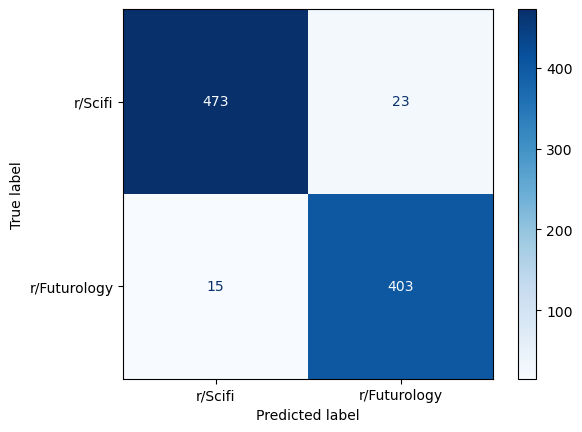

In [205]:

ConfusionMatrixDisplay.from_estimator(pipe_nb, X_test, y_test, cmap = 'Blues', display_labels=['r/Scifi', 'r/Futurology'])
#ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, cmap = 'Blues')
#ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, cmap = 'Blues', display_labels=['r/Scifi', 'r/Futurology'])

In [206]:
recall_score(y_test, y_preds)

0.9641148325358851

## Gridsearch

In [146]:
# %%time
# gs = GridSearchCV(pipe_svc, pgrid, cv = 5, n_jobs = 12)
# #rs = RandomizedSearchCV(pipe_rf, pgrid, cv = 5, n_jobs = 12)

# gs.fit(X_train, y_train)
# #rs.fit(X_train, y_train)
# best_params = gs.best_params_


CPU times: total: 516 ms
Wall time: 12.9 s


In [147]:
# gs.best_params_

{'svc__C': 1.0, 'svc__degree': 1, 'svc__kernel': 'poly'}

In [148]:
# gs.score(X_train, y_train)

0.9715536105032823

In [149]:
#gs.score(X_test, y_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9332603938730853

In [150]:
#y_preds = gs.predict(X_test)
#y_preds = gs.predict(X_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Post-Gridsearch Evaluation

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


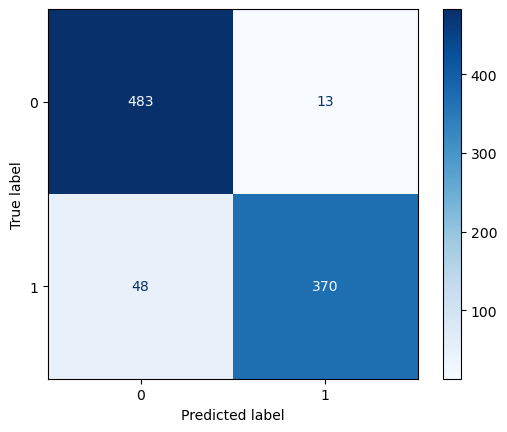

In [151]:
#ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap = 'Blues')

In [152]:
#recall_score(y_test, y_preds)

0.8851674641148325

In [209]:
results = pd.DataFrame({
    'actually Futurology' : y_test,
    'predicted Futurology' : y_preds
})

false_positives = results[(results['actually Futurology'] == 0) & (results['predicted Futurology'] == 1)].index

false_positives

In [220]:
reddit_data_df.iloc[false_positives, 2].to_frame()

,title
3300,"In the 60s ""Astronaut happiness wasn’t a factor” say historian David Hitt. On Skylab 4, in 1973, the crew be overwork with packed schedule each day. They tell NASA they couldn't keep up. This event be misreported as a ""mutiny,"" but it have big effects. Astronauts now work 9-5, with weekend off."
2342,Races and creature from other planet or dimensions?
2446,The moon and tectonics
3153,Time to come in
1766,Ice 9
2489,Future eyewear (@m0ds.lab instagram)
1878,Some of Shinji Aramaki’s production sketch from Bubblegum Crisis
1995,High as the moon
2152,Life 2017
3451,"A cleric fight against a system he once defend where expression & feeling be outlaw in, Equilibrium (2002)."


In [275]:
results[results['actually Futurology'] != results['predicted Futurology']]

,actually Futurology,predicted Futurology
id,,
mpeykb,0,1
166gns0,1,0
15qqpot,1,0
16i563y,1,0
15uiq28,1,0
16ar3u8,1,0
178osme,0,1
16m2duk,0,1
165yzac,1,0
